# Using DCRNN for speed prediction of the traffic

The details about the data is shown in the notebook
https://github.com/mhmdrdwn/traffic/blob/main/notebooks/tgcn-seoul-dataset.ipynb

The data: https://github.com/yuyolshin/SeoulSpeedData

In [1]:
import torch
from IPython.display import clear_output

pt_version = torch.__version__

!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-${pt_version}.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-${pt_version}.html
!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-${pt_version}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-${pt_version}.html
!pip install torch-geometric
!pip install torch-geometric-temporal
clear_output()

## Using Seoul Urban Core Data

In [2]:
import numpy as np
import pandas as pd

def read_data(features_csv, adj_csv):
    urban_core_speeds = pd.read_csv(features_csv, header=None)
    adj_matrix_df = pd.read_csv(adj_csv, header=None)
    adj_matrix = np.array(adj_matrix_df)

    speeds_df = urban_core_speeds.iloc[:, 7:]
    speeds = np.array(speeds_df)
    
    return adj_matrix_df, urban_core_speeds, adj_matrix, speeds

adj_matrix_df, urban_core_speeds, adj_matrix, speeds = read_data(
    '../input/seoul-speed-data/urban-core.csv', 
    '../input/seoul-speed-data/Adj(urban-core).csv')

In [3]:
"""Train test split the data"""
train_test_split = 0.75

split = int(speeds.shape[1] * train_test_split)
train_data = speeds[:, :split-int(0.1*split)]
test_data = speeds[:, split:]
val_data = speeds[:, split-int(0.1*split):split]

print("Train data: ", train_data.shape)
print("Test data: ", test_data.shape)
print("Val data: ", val_data.shape)

Train data:  (304, 5832)
Test data:  (304, 2160)
Val data:  (304, 648)


In [4]:
"""Min max standardizing the data"""
max_speed = train_data.max()
min_speed = train_data.min()

train_data = (train_data - min_speed) / (max_speed - min_speed)
test_data = (test_data - min_speed) / (max_speed - min_speed)
val_data = (val_data - min_speed) / (max_speed - min_speed)

train_data.shape, test_data.shape, val_data.shape

((304, 5832), (304, 2160), (304, 648))

Here we build the features and labels of the time series, The features vectors are of length 10 while the prediction is the next step in the sequence. The model can predict a sequence too where the preiction length can be more than 1. 

In [5]:
"""Ref: https://stellargraph.readthedocs.io/en/stable/demos/time-series/gcn-lstm-time-series.html"""

sequence_len = 10
prediction_len = 1

def build_features_labels(sequence_len, prediction_len, train_data, test_data, val_data):
    X_train, Y_train, X_test, Y_test, X_val, Y_val = [], [], [], [], [], []

    for i in range(train_data.shape[1] - int(sequence_len + prediction_len - 1)):
        a = train_data[:, i : i + sequence_len + prediction_len]
        X_train.append(a[:, :sequence_len])
        Y_train.append(a[:, sequence_len:sequence_len+prediction_len])

    for i in range(test_data.shape[1] - int(sequence_len + prediction_len - 1)):
        b = test_data[:, i : i + sequence_len + prediction_len]
        X_test.append(b[:, :sequence_len])
        Y_test.append(b[:, sequence_len:sequence_len+prediction_len])
        
    for i in range(val_data.shape[1] - int(sequence_len + prediction_len - 1)):
        b = val_data[:, i : i + sequence_len + prediction_len]
        X_val.append(b[:, :sequence_len])
        Y_val.append(b[:, sequence_len:sequence_len+prediction_len])
        
    X_train = np.array(X_train)
    Y_train = np.array(Y_train)
    X_test = np.array(X_test)
    Y_test = np.array(Y_test)
    X_val = np.array(X_val)
    Y_val = np.array(Y_val)
    
    return X_train, Y_train, X_test, Y_test, X_val, Y_val

X_train, Y_train, X_test, Y_test, X_val, Y_val = build_features_labels(sequence_len, 
                                                                       prediction_len, 
                                                                       train_data, 
                                                                       test_data, 
                                                                       val_data)

X_train_shape = X_train.shape
X_test_shape = X_test.shape
X_val_shape = X_val.shape

X_train = X_train.reshape(X_train_shape[0], X_train_shape[1], X_train_shape[2])
X_test = X_test.reshape(X_test_shape[0], X_test_shape[1], X_test_shape[2])
X_val = X_val.reshape(X_val_shape[0], X_val_shape[1], X_val_shape[2])
Y_train = Y_train.reshape(Y_train.shape[0], Y_train.shape[1])
Y_test = Y_test.reshape(Y_test.shape[0], Y_test.shape[1])
Y_val = Y_val.reshape(Y_val.shape[0], Y_val.shape[1])

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)
print(X_val.shape)
print(Y_val.shape)

(5822, 304, 10)
(5822, 304)
(2150, 304, 10)
(2150, 304)
(638, 304, 10)
(638, 304)


We need to convert the input data into graph temporal object to feed to the model in the torch geometric library, The object we use here is Static Graph Temporal Signal. There are other object that are Dynamic. In Dynamic, we expect that the graph changes over time but here the graph topology does not change over time. We take the adjacency matrix and get the indices where there are connections between nodes and call it edge index. Edge attribute is the value of the connection between nodes. Those two are passed along with the traditional X and y (X is 10 steps in time series whie y is the next step in the series).

In [6]:
edges = np.nonzero(adj_matrix)
edges = np.vstack([edges, adj_matrix[edges]])
edge_index = edges[:2, :].astype(float)
edge_attr = edges[2, :].astype(float)
print('Edges shape: ', edge_index.shape, ', Attr shape: ',edge_attr.shape)

from torch_geometric_temporal.signal import StaticGraphTemporalSignal
train_loader = StaticGraphTemporalSignal(edge_index, edge_attr, X_train, Y_train)
test_loader = StaticGraphTemporalSignal(edge_index, edge_attr, X_test, Y_test)
val_loader = StaticGraphTemporalSignal(edge_index, edge_attr, X_val, Y_val)
next(iter(train_loader))

Edges shape:  (2, 1696) , Attr shape:  (1696,)


Data(x=[304, 10], edge_index=[2, 1696], edge_attr=[1696], y=[304])

The DCRNN model (Diffusion Convolutional Recurrent Neural Network) https://arxiv.org/abs/1707.01926. The model uses diffusion convolution to handle complex spatial dependency, RNN (GRU) to handle temporal dynamics and encoder-decoder architecture to handle long term dependecny. Diffusion convolution is used to quantify the reachability between the nodes in the graphs (each node to surrouding nodes which influence it). The the diffusion cnvolution equation from the paper contains convolution kernel, features matrix (input) and adjacency matrix. This is done by convolution of the node own features, then add convolution of nearest connected nodes features, and the convolving the second nearest neighbour features and so on. A brief explanation with mathimatical explanation of the diffusion convolution is here https://www.youtube.com/watch?v=lN8HrGFK3l0

In Gated Recurrent Units (GRU), the diffusion convolution will substitute the matrix multiplications in GRU set of equations to form DCGRU. The encoder-decoder is a standard sequence to sequence model. Both the encoder and the decoder are DCGRU. Historical time series are fed into the encoder and use its final states are fed to the decoder. Finally, the decoder makes predictions based on either previous ground truth or the model output.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``np.array(PIL.Image.open(urllib.request.urlopen(url)))``.
  


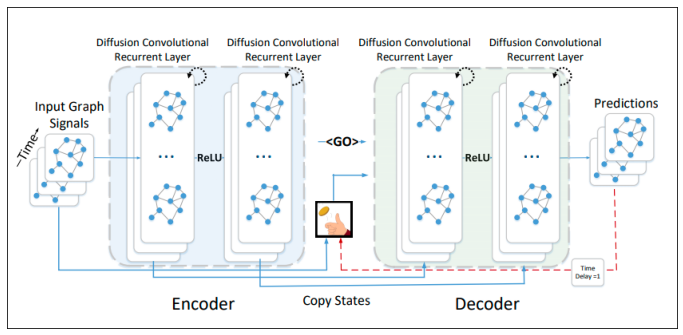

In [42]:
"""Ref: https://arxiv.org/abs/1707.01926"""
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(12,12))
plt.imshow(mpimg.imread('https://raw.githubusercontent.com/mhmdrdwn/traffic/main/plots/dcrnn.png'))
plt.tick_params(axis='both', which='both', bottom=False, top=False, 
                left=False,right=False, labelleft=False, labelbottom=False) 
plt.show()

In [7]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import DCRNN

class DCRNNModel(torch.nn.Module):
    def __init__(self, node_features):
        super(DCRNNModel, self).__init__()
        self.dcrnn = DCRNN(node_features, 32, 1)
        self.linear = torch.nn.Linear(32, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.dcrnn(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

In [29]:
def evaluate_model(model, val_loader):
    loss = 0
    step = 0
    model.eval()
    with torch.no_grad():
        for snapshot in val_loader:
            snapshot = snapshot.to(device)
            y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
            loss = loss + torch.mean(torch.abs(y_hat-snapshot.y)) 
            step += 1
        loss = loss / (step + 1)
    
    print("Val MAE: {:.4f}".format(loss.item()))
    return loss

In [30]:
model = DCRNNModel(node_features = 10)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

train_losses, val_losses = [], []

for epoch in range(50):
    print('Epoch: ', epoch+1)
    print('==========')
    loss = 0
    
    model.train()
    for time, snapshot in enumerate(train_loader):
        snapshot = snapshot.to(device)
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        loss = loss + torch.mean(torch.abs(y_hat-snapshot.y))
    loss = loss / (time+1)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    train_losses.append(loss.item())
    
    print("Train MAE: {:.4f}".format(loss.item()))
    
    va_loss = evaluate_model(model, val_loader)
    val_losses.append(va_loss.item())

Epoch:  1
Train MAE: 0.3348
Val MAE: 0.2734
Epoch:  2
Train MAE: 0.2647
Val MAE: 0.1966
Epoch:  3
Train MAE: 0.1909
Val MAE: 0.1240
Epoch:  4
Train MAE: 0.1236
Val MAE: 0.1065
Epoch:  5
Train MAE: 0.1091
Val MAE: 0.1400
Epoch:  6
Train MAE: 0.1409
Val MAE: 0.1547
Epoch:  7
Train MAE: 0.1549
Val MAE: 0.1453
Epoch:  8
Train MAE: 0.1460
Val MAE: 0.1243
Epoch:  9
Train MAE: 0.1261
Val MAE: 0.1044
Epoch:  10
Train MAE: 0.1071
Val MAE: 0.0954
Epoch:  11
Train MAE: 0.0978
Val MAE: 0.0985
Epoch:  12
Train MAE: 0.0997
Val MAE: 0.1068
Epoch:  13
Train MAE: 0.1066
Val MAE: 0.1130
Epoch:  14
Train MAE: 0.1118
Val MAE: 0.1141
Epoch:  15
Train MAE: 0.1125
Val MAE: 0.1102
Epoch:  16
Train MAE: 0.1089
Val MAE: 0.1030
Epoch:  17
Train MAE: 0.1026
Val MAE: 0.0953
Epoch:  18
Train MAE: 0.0959
Val MAE: 0.0895
Epoch:  19
Train MAE: 0.0913
Val MAE: 0.0874
Epoch:  20
Train MAE: 0.0900
Val MAE: 0.0886
Epoch:  21
Train MAE: 0.0917
Val MAE: 0.0908
Epoch:  22
Train MAE: 0.0941
Val MAE: 0.0920
Epoch:  23
Train MA

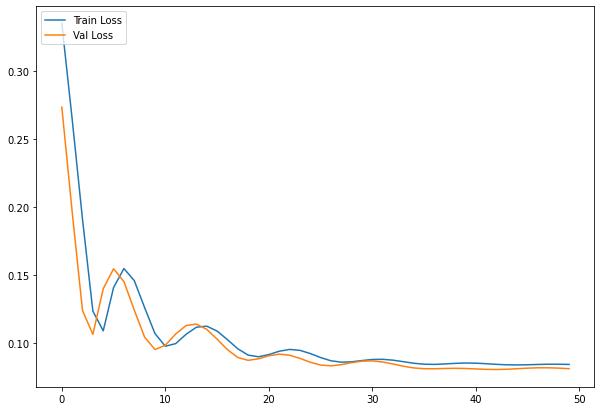

In [31]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
plt.plot(range(len(val_losses)), val_losses, label='Val Loss')
plt.legend(loc="upper left")
plt.show()

In [32]:
"""Make predictions for test data"""
model.eval()
y_preds = list()
y_true = list()

for snapshot in test_loader:
    y = snapshot.y.cpu().numpy().reshape(-1)
    y_pred = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr).view(len(snapshot.x), -1).cpu().detach().numpy().reshape(-1)

    y = np.array(y * max_speed)
    y_pred = np.array((y_pred) * max_speed)
    y_preds.extend(list(y_pred))
    y_true.extend(list(y))
    
y_preds = np.array(y_preds)
y_true = np.array(y_true)
y_preds = y_preds.reshape(int(y_preds.shape[0]/304), 304)
y_true = y_true.reshape(int(y_true.shape[0]/304), 304)

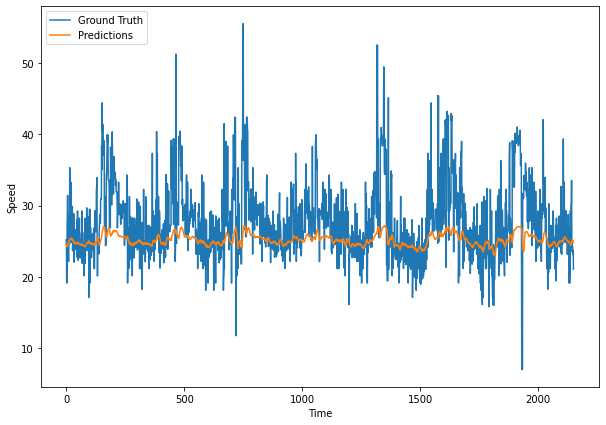

In [41]:
"""show one sensor time series"""
y_sample = y_true[:, 100]
y_pred_sample = y_preds[:, 100]

plt.figure(figsize=(10,7))
plt.plot(range(len(y_sample)), y_sample, label='Ground Truth')
plt.plot(range(len(y_pred_sample)), y_pred_sample, label='Predictions')
plt.xlabel('Time')
plt.ylabel('Speed')
plt.legend(loc="upper left")
plt.show()

In [34]:
"""Overall evaluation the predictions of the test data"""
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true +=  0.000001 #add small values to true velocities to avoid division by zeros
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print('RMSE: ', np.sqrt(mean_squared_error(y_true, y_preds)))
print('MAE: ', np.sqrt(mean_absolute_error(y_true, y_preds)))
print('MAPE: ', np.sqrt(mean_absolute_percentage_error(y_true, y_preds)), "%")

RMSE:  9.919324
MAE:  2.6237566
MAPE:  5.377325708108785 %


# References:

- Shin, Y., & Yoon, Y. (2020). Incorporating dynamicity of transportation network with multi-weight traffic graph convolutional network for traffic forecasting. IEEE Transactions on Intelligent Transportation Systems.

- Li, Yaguang & Yu, Rose & Shahabi, Cyrus & Liu, Yan. (2018). Diffusion Convolutional Recurrent Neural Network: Data-Driven Traffic Forecasting. 

- https://stellargraph.readthedocs.io/en/stable/demos/time-series/gcn-lstm-time-series.html

- https://pytorch-geometric-temporal.readthedocs.io/en/latest/_modules/torch_geometric_temporal/nn/recurrent/dcrnn.html

- https://pytorch-geometric-temporal.readthedocs.io/en/latest/notes/introduction.html